In [17]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [18]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
import cv2
from PIL import Image
from matplotlib import pyplot as plt, rcParams, animation


In [19]:
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))
    
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf

In [20]:
# load the model
features_blobs = []

#model_file = 'wideresnet18_places365.pth.tar'
#import wideresnet
#model = wideresnet.resnet18(num_classes=365)

arch = 'resnet18'
model_file = 'checkpoint_003_done.pth.tar'
model = models.__dict__[arch](num_classes=3)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {k[2:]: v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()
    
# hook the feature extractor
features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
for name in features_names:
    model._modules.get(name).register_forward_hook(hook_feature)


In [21]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [22]:
# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

# 365 categories X 512 features
weight_softmax.shape

(3, 512)

In [23]:
# load the transformer
tf = returnTF() # image transformer

In [33]:
# load the test images from the BroDen dataset
import glob
files = glob.glob('./broden1_224/images/pascal/*.jpg')
len(files)




10103

In [34]:
files[0]

'./broden1_224/images/pascal/2008_007250.jpg'

In [35]:
# load the test image
#img_url = 'http://places2.csail.mit.edu/imgs/12.jpg'
#os.system('wget %s -q -O test.jpg' % img_url)

idx = 1234

img = Image.open(files[idx][:3]+'_color.png')
tf_img = tf(img)
input_img = V(tf_img.unsqueeze(0))

tf_img = np.rollaxis(tf_img.numpy(),0,3)

plt.imshow(img)


FileNotFoundError: [Errno 2] No such file or directory: './b_color.png'

In [27]:
#plt.imshow(tf_img)


In [28]:
# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [29]:
# output the prediction of scene category
classes = ['indoor', 'nature', 'outdoor']
print('--SCENE CATEGORIES:')
for i in range(0, 3):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

--SCENE CATEGORIES:
0.953 -> indoor
0.027 -> nature
0.020 -> outdoor


[512, 7, 7]
[(1, 512), (1, 49)]
(7, 7)


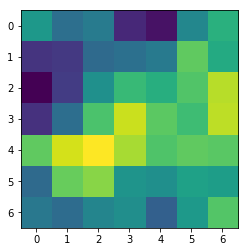

In [30]:
feature_conv = features_blobs[0]
class_idx = [idx[0]]

nc, h, w = feature_conv.shape
print([nc, h, w])
cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
# 14 x 14 = 196
print([weight_softmax[class_idx].shape, cam.shape])
cam = cam.reshape(h, w)
print(cam.shape)
# scalining
cam = cam - np.min(cam)
cam_img = cam / np.max(cam)

#print(cam_img)
plt.imshow(cam_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


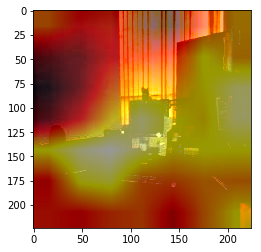

In [31]:
import scipy
plt.imshow(tf_img)
plt.imshow(scipy.misc.imresize(cam_img, tf_img.shape), alpha=0.6, cmap='hot');